# Import packages

In [1]:
import os
import csv
from pathlib import Path
from copy import deepcopy
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib
import pickle

import torch
from lightning import pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import Callback

from chemprop import data, featurizers, models, nn

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

import logging

# logging.getLogger('lightning').setLevel(0)

# configure logging at the root level of Lightning
# logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

# configure logging on module level, redirect to file
# logger = logging.getLogger("lightning.pytorch.core")
# logger.addHandler(logging.FileHandler("core.log"))

# logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.ERROR)
# logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)

# logging.getLogger("lightning.fabric.plugins.environments.slurm").setLevel(logging.ERROR)
# logging.getLogger("lightning.pytorch.callbacks.model_checkpoint").setLevel(logging.ERROR)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

# from xgboost import XGBRegressor

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from skopt.plots import plot_objective
# from skopt.plots import plot_convergence

## Load data

In [3]:
chemprop_dir = Path.cwd().parent
data_path = '../train_split_fluor.csv'

smiles_columns = ['Chromophore', 'Solvent']
target_columns = ['Absorption max (nm)', 'Emission max (nm)', 'log qyield']
# target_columns = ['Quantum yield']

In [4]:
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
batch_size = 512

In [5]:
data_df = pd.read_csv(data_path)

## Preprocess data

In [6]:
def dropna(df):
    return df.dropna(subset=['Absorption max (nm)', 'Emission max (nm)', 'Stokes shift', 'Quantum yield'], how='all')

def replace_gas(df):
    df.loc[df['Solvent'] == 'gas', 'Solvent'] = df['Chromophore']
    return df

def remove_neg_shift(df):
    return df[(df['Stokes shift'] >= 0.0) | (df['Stokes shift'].isna())]

def make_log_qyield(df):
    df_tmp = df.copy()
    df_tmp.loc[df_tmp['Quantum yield'] == 0.0, 'Quantum yield'] = 1e-5
    df_tmp.loc[:, 'log qyield'] = np.log(df_tmp['Quantum yield'])
    return df_tmp

def preprocess_data(df):
    df = dropna(df)
    df = replace_gas(df)
    df = remove_neg_shift(df)
    df = make_log_qyield(df)
    return df

In [7]:
data_clean = preprocess_data(data_df)
data_clean.shape

(18110, 17)

In [8]:
test_data_df = pd.read_csv('../test_split_fluor.csv')
test_data_df.shape

(1850, 16)

In [9]:
test_data_clean = replace_gas(test_data_df)
test_data_clean = make_log_qyield(test_data_clean)
test_data_clean.shape

(1850, 17)

### Prepare data for training

In [10]:
smiss = data_clean.loc[:, smiles_columns].values
ys = data_clean.loc[:, target_columns].values

In [11]:
test_smiss = test_data_clean.loc[:, smiles_columns].values
test_ys = test_data_clean.loc[:, target_columns].values

In [12]:
smiss.shape

(18110, 2)

In [13]:
all_data = [[data.MoleculeDatapoint.from_smi(smis[0], y) for smis, y in zip(smiss, ys)]]
all_data += [[data.MoleculeDatapoint.from_smi(smis[i]) for smis in smiss] for i in range(1, len(smiles_columns))]

In [14]:
test_data = [[data.MoleculeDatapoint.from_smi(smis[0], y) for smis, y in zip(test_smiss, test_ys)]]
test_data += [[data.MoleculeDatapoint.from_smi(smis[i]) for smis in test_smiss] for i in range(1, len(smiles_columns))]

In [15]:
component_to_split_by = 1
mols = [d.mol for d in all_data[component_to_split_by]]
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.9, 0.05, 0.05))
val_indices += test_indices
train_data, val_data, _ = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

In [16]:
len(train_data[0]) + len(val_data[0])

18110

In [17]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_datasets = [data.MoleculeDataset(train_data[i], featurizer) for i in range(len(smiles_columns))]
val_datasets = [data.MoleculeDataset(val_data[i], featurizer) for i in range(len(smiles_columns))]
test_datasets = [data.MoleculeDataset(test_data[i], featurizer) for i in range(len(smiles_columns))]

In [18]:
train_mcdset = data.MulticomponentDataset(train_datasets)

scaler = train_mcdset.normalize_targets()

val_mcdset = data.MulticomponentDataset(val_datasets)
val_mcdset.normalize_targets(scaler)

test_mcdset = data.MulticomponentDataset(test_datasets)

In [19]:
train_loader = data.build_dataloader(train_mcdset, batch_size=batch_size)
val_loader = data.build_dataloader(val_mcdset, shuffle=False, batch_size=batch_size)
test_loader = data.build_dataloader(test_mcdset, shuffle=False, batch_size=batch_size)

In [20]:
batch = next(iter(val_loader))

## Training

In [21]:
mcmp = nn.MulticomponentMessagePassing(
    blocks=[
        nn.BondMessagePassing(
                d_h=512,
                dropout=0.1,
                depth=3,
                bias=True
            )
        for _ in range(len(smiles_columns))],
    n_components=len(smiles_columns),
)

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

ffn = nn.RegressionFFN(
    n_tasks=len(target_columns),
    output_transform=output_transform,
    input_dim=mcmp.output_dim,
    hidden_dim=512,
    n_layers=4,
    dropout=0.5,
    activation="relu"
)

mpnn = models.MulticomponentMPNN(
    mcmp,
    nn.MeanAggregation(),
    ffn,
    batch_norm=True,
    warmup_epochs=5,
    # init_lr=1e-5,
    max_lr=1e-3,
    # final_lr=1e-4,
    metrics=[nn.metrics.RMSEMetric()],
)

mpnn

MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=86, out_features=512, bias=True)
        (W_h): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=584, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=1024, out_features=512, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (2): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.5, inplace=

# Set up trainer

In [268]:
checkpoint_cb = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath="model_2",
    filename="{epoch:03d}-{val_loss:.3f}"
)

earlystopping_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=15,
    min_delta=0.0
)

# class MetricTracker(Callback):
#     def __init__(self):
#         self.collection = []
    
#     def on_validation_batch_end(trainer, module, outputs, ...):
#         vacc = outputs['val_acc'] # you can access them here
#         self.collection.append(vacc) # track them
    
#     def on_validation_epoch_end(trainer, module):
#         elogs = trainer.logged_metrics # access it here
#         self.collection.append(elogs)
#         # do whatever is needed


trainer = pl.Trainer(
    logger=True,
    enable_progress_bar=True,
    accelerator="cuda",
    devices=[0],
    min_epochs=5,
    max_epochs=200,
    callbacks=[checkpoint_cb, earlystopping_cb],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Start training

In [269]:
trainer.fit(mpnn, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/kashurin/soft/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name            | Type                         | Params | Mode 
-------------------------------------------------------------------------
0 | message_passing | MulticomponentMessagePassing | 1.2 M  | train
1 | agg             | MeanAggregation              | 0      | train
2 | bn              | BatchNorm1d                  | 2.0 K  | train
3 | predictor       | RegressionFFN                | 1.3 M  | train
4 | X_d_transform   | Identity                     | 0      | train
-------------------------------------------------------------------------
2.5 M     Trainable p

Epoch 199: 100%|██████████| 32/32 [00:18<00:00,  1.72it/s, v_num=7, train_loss=0.0678, val_loss=0.342]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s, v_num=7, train_loss=0.0678, val_loss=0.342]


In [270]:
earlystopping_cb.best_score

tensor(0.3416, device='cuda:0')

In [271]:
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs

### Test results

In [273]:
ckpt_path = [None, 'model_'][0]
if ckpt_path is None:
    ckpt_path = 'best'
results = trainer.test(mpnn, test_loader, ckpt_path=ckpt_path)

Restoring states from the checkpoint path at /home/kashurin/gnn_1/model_2/epoch=199-val_loss=0.342.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/kashurin/gnn_1/model_2/epoch=199-val_loss=0.342.ckpt


Testing DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
batch_averaged_test/rmse    19.345558166503906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [274]:
results

[{'batch_averaged_test/rmse': 19.345558166503906}]

In [275]:
checkpoint_cb.best_model_path

'/home/kashurin/gnn_1/model_2/epoch=199-val_loss=0.342.ckpt'

In [23]:
# ckpt_path = checkpoint_cb.best_model_path
ckpt_path = '/home/kashurin/gnn_1/model_2/epoch=199-val_loss=0.342.ckpt'

mpnn_predict = mpnn

with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        devices=[0]
    )
    testing_preds = trainer.predict(mpnn_predict, test_loader, ckpt_path=ckpt_path)

testing_preds = np.concatenate(testing_preds, axis=0)

/home/kashurin/soft/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kashurin/soft/miniconda3/envs/chemprop/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kashurin/soft/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to en

Predicting: |                                                                                                |…

In [24]:
def rmsd(pred, target):
    mask = ~np.isnan(pred) & ~np.isnan(target)
    return root_mean_squared_error(pred[mask], target[mask])

In [25]:
print(f"RMSD Absorption max, nm: {rmsd(testing_preds[:, 0], test_ys[:, 0])}")
print(f"RMSD Emission max, nm: {rmsd(testing_preds[:, 1], test_ys[:, 1])}")
print(f"RMSD Log quantum yield, nm: {rmsd(testing_preds[:, 2], test_ys[:, 2])}")

RMSD Absorption max, nm: 21.02335147483124
RMSD Emission max, nm: 25.32811689562642
RMSD Log quantum yield, nm: 0.9610144623119536


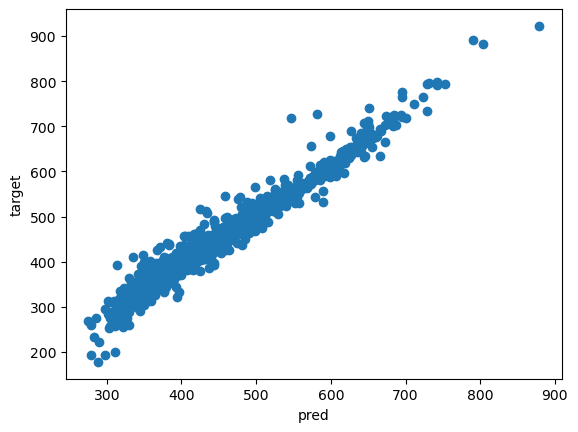

In [279]:
plt.scatter(testing_preds[:, 0], test_ys[:, 0])
plt.xlabel('pred')
plt.ylabel('target')
plt.show()

In [26]:
def r2(pred, target):
    mask = ~np.isnan(pred) & ~np.isnan(target)
    return np.corrcoef(pred[mask], target[mask])[0, 1]**2

In [27]:
print(f"R2 Absorption max: {r2(testing_preds[:, 0], test_ys[:, 0])}")
print(f"R2 Emission max: {r2(testing_preds[:, 1], test_ys[:, 1])}")
print(f"R2 Log quantum yield: {r2(testing_preds[:, 2], test_ys[:, 2])}")

R2 Absorption max: 0.9648811407909756
R2 Emission max: 0.9380774156667805
R2 Log quantum yield: 0.7580516759530557


## CV training

In [125]:
def cv_score_model(params, training_data, k=5, cv_dir='cv', seed=42):
    global patience, min_delta, save_chekpoint, max_checkpoints_to_keep
    global min_epochs, max_epochs

    if save_chekpoint:
        if not os.path.exists(cv_dir):
            os.makedirs(cv_dir)
    save_dir = None
    
    min_val_scores = []

    # make cv splits
    mols = [d.mol for d in training_data]
    train_indices, val_indices, test_indices = data.make_split_indices(
        mols,
        "cv_no_val",
        num_folds=k,
        seed=seed
    )
    val_indices = test_indices
    

    for fold in range(k):
        start = time.time()

        if save_chekpoint:
            save_dir = f'{cv_dir}/m{fold}'

        # split data
        train_data, val_data, test_data = data.split_data_by_indices(
            training_data,
            train_indices[fold], val_indices[fold], test_indices[fold]
        )

        # make datasets
        train_dset = data.MoleculeDataset(train_data, featurizer)
        scaler = train_dset.normalize_targets()
        
        val_dset = data.MoleculeDataset(val_data, featurizer)
        val_dset.normalize_targets(scaler)
        
        test_dset = data.MoleculeDataset(test_data, featurizer)

        # make loaders
        train_loader = data.build_dataloader(train_dset, num_workers=num_workers,
                                             seed=seed, batch_size=params['batch_size'])
        val_loader = data.build_dataloader(val_dset, num_workers=num_workers,
                                           shuffle=False, batch_size=params['batch_size'])
        test_loader = data.build_dataloader(test_dset, num_workers=num_workers,
                                            shuffle=False, batch_size=params['batch_size'])

        # make model
        mp = nn.BondMessagePassing(
            d_h=params['message_hidden_dim'],
            depth=params['depth'],
            dropout=params['message_dropout'],
            bias=True
        )
        
        ffn = nn.RegressionFFN(
            output_transform=nn.UnscaleTransform.from_standard_scaler(scaler),
            input_dim=mp.output_dim,
            hidden_dim=params['ffn_hidden_dim'],
            n_layers=params['ffn_num_layers'],
            dropout=params['ffn_dropout'],
            activation="relu"
        )
        
        mpnn = models.MPNN(
            mp,
            nn.MeanAggregation(),
            ffn,
            batch_norm=True,
            warmup_epochs=params['warmup_epochs'],
            init_lr=params['init_lr'],
            max_lr=params['max_lr'],
            final_lr=params['final_lr'],
            metrics=[nn.metrics.RMSEMetric()],
        )
        
        # make trainer
        checkpoint_cb = ModelCheckpoint(
            save_top_k=max_checkpoints_to_keep,
            monitor="val_loss",
            mode="min",
            dirpath=save_dir,
            filename="{epoch:03d}-{val_loss:.3f}",
        )
        
        earlystopping_cb = EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=patience,
            min_delta=min_delta,
        )

        trainer = pl.Trainer(
            logger=False,
            enable_progress_bar=False,
            accelerator="cuda",
            devices=[1],
            min_epochs=min_epochs,
            max_epochs=max_epochs,
            callbacks=[checkpoint_cb, earlystopping_cb],
        )

        # training
        trainer.fit(mpnn, train_loader, val_loader)
        
        # predicting
        results = trainer.test(mpnn, test_loader, ckpt_path="best")

        min_val_score = results[0]['batch_averaged_test/rmse']
        min_val_scores.append(min_val_score)
        end = time.time()

        print(f'Fold {fold+1}/{k}; Time {end-start:.3f};', end=' ')
        print(f'Min val score {min_val_score:.3f}; Training epochs {mpnn.current_epoch}')

    mean_min_val_score = np.mean(min_val_scores)
    si_min_val_score = np.std(min_val_scores)

    return mean_min_val_score, si_min_val_score, min_val_scores

In [126]:
cv_dir = 'cv_v2.2'

patience = 35
min_delta = 0.0
save_chekpoint = True
max_checkpoints_to_keep = 1

parameters = {
    'batch_size': 128,
    'warmup_epochs': 4,
    'init_lr': 1e-4,
    'max_lr': 1e-3,
    'final_lr': 1e-4,
    'message_hidden_dim': 2**6,
    'depth': 6,
    'message_dropout': 0.2,
    'ffn_hidden_dim': 2**9,
    'ffn_num_layers': 5,
    'ffn_dropout': 0.2,
}

min_epochs = 50
max_epochs = 300
k_folds = 10
seed=43

In [127]:
%%time
mean_min_val_score, si_min_val_score, min_val_scores = cv_score_model(
    parameters,
    training_data,
    k=k_folds,
    cv_dir = cv_dir,
)

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.224790573120117     │
└───────────────────────────┴───────────────────────────┘

Fold 1/10; Time 73.523; Min val score 24.225; Training epochs 126


/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.586816787719727     │
└───────────────────────────┴───────────────────────────┘

Fold 2/10; Time 65.537; Min val score 25.587; Training epochs 110


/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    21.396167755126953     │
└───────────────────────────┴───────────────────────────┘

Fold 3/10; Time 56.854; Min val score 21.396; Training epochs 97


/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.538761138916016     │
└───────────────────────────┴───────────────────────────┘

Fold 4/10; Time 51.327; Min val score 24.539; Training epochs 97


/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     26.37315559387207     │
└───────────────────────────┴───────────────────────────┘

Fold 5/10; Time 42.413; Min val score 26.373; Training epochs 78


/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.342388153076172     │
└───────────────────────────┴───────────────────────────┘

Fold 6/10; Time 60.266; Min val score 25.342; Training epochs 103


/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     21.34317398071289     │
└───────────────────────────┴───────────────────────────┘

Fold 7/10; Time 63.210; Min val score 21.343; Training epochs 107


/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    19.805280685424805     │
└───────────────────────────┴───────────────────────────┘

Fold 8/10; Time 65.085; Min val score 19.805; Training epochs 120


/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    22.615842819213867     │
└───────────────────────────┴───────────────────────────┘

Fold 9/10; Time 41.866; Min val score 22.616; Training epochs 76


/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.661935806274414     │
└───────────────────────────┴───────────────────────────┘

Fold 10/10; Time 61.524; Min val score 24.662; Training epochs 115
CPU times: user 10h 1min 55s, sys: 13min 55s, total: 10h 15min 50s
Wall time: 9min 41s


In [128]:
mean_min_val_score, si_min_val_score

(23.5888313293457, 2.0588940150078154)

## Predicting

In [134]:
mpnn_predict = models.MPNN.load_from_checkpoint(f"{cv_dir}/m7/epoch=084-val_loss=0.544.ckpt")

In [163]:
mpnn_predict

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=64, bias=True)
    (W_h): Linear(in_features=64, out_features=64, bias=True)
    (W_o): Linear(in_features=136, out_features=64, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=512, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (2): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (3): Sequential(
        (0): ReLU()
        (1): 

In [138]:
testing_data = [data.MoleculeDatapoint.from_smi(smi, add_h=False) for smi in testing_smis]
testing_dset = data.MoleculeDataset(testing_data, featurizer)
testing_loader = data.build_dataloader(testing_dset, shuffle=False, batch_size=128)

In [151]:
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        devices=[1]
    )
    testing_preds = trainer.predict(mpnn_predict, testing_loader)

testing_preds = list(np.concatenate(testing_preds, axis=0).ravel())

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.73it/s]


In [153]:
with open('pred_13.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Results'])
    for result in testing_preds:
        writer.writerow([result])

In [156]:
ckpts = [
    'epoch=090-val_loss=0.665.ckpt',
    'epoch=074-val_loss=0.705.ckpt',
    'epoch=061-val_loss=0.585.ckpt',
    'epoch=061-val_loss=0.666.ckpt',
    'epoch=042-val_loss=0.726.ckpt',
    'epoch=067-val_loss=0.692.ckpt',
    'epoch=071-val_loss=0.585.ckpt',
    'epoch=084-val_loss=0.544.ckpt',
    'epoch=040-val_loss=0.620.ckpt',
    'epoch=079-val_loss=0.677.ckpt',
]
ensemble = []
for i in range(k_folds):
    ensemble.append(
        models.MPNN.load_from_checkpoint(f"{cv_dir}/m{i}/{ckpts[i]}")
    )

In [159]:
with torch.inference_mode():
    predictions = []
    for i in range(k_folds):
        tmp_model = ensemble[i]
        trainer = pl.Trainer(
            logger=None,
            enable_progress_bar=False,
            devices=[1]
        )
        preds = trainer.predict(tmp_model, testing_loader)
        predictions.append(torch.concat(preds))
    
    testing_preds = list(torch.concat(predictions, axis=1).mean(axis=1).tolist())

In [162]:
with open('pred_14.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Results'])
    for result in testing_preds:
        writer.writerow([result])

## HP Optimization

In [74]:
def objective(space):
    global patience, min_delta, save_chekpoint, max_checkpoints_to_keep
    global min_epochs, max_epochs, cv_dir

    parameters = {
        'batch_size': space['batch_size'],
        'warmup_epochs': space['warmup_epochs'],
        'init_lr': space['init_lr_ratio'] * space['max_lr'],
        'max_lr': space['max_lr'],
        'final_lr': space['final_lr_ratio'] * space['max_lr'],
        'message_hidden_dim': space['message_hidden_dim'],
        'depth': space['depth'],
        'message_dropout': space['message_dropout'],
        'ffn_hidden_dim': space['ffn_hidden_dim'],
        'ffn_num_layers': space['ffn_num_layers'],
        'ffn_dropout': space['ffn_dropout'],
    }

    mean_min_val_score, si_min_val_score, min_val_scores = cv_score_model(
        parameters,
        training_data,
        k=k_folds,
        cv_dir=cv_dir,
    )

    return {
        'loss': mean_min_val_score,
        'status': STATUS_OK,
        'si_loss': si_min_val_score,
        'folds_loss': min_val_scores,
    }

In [75]:
search_space = {
    'batch_size': hp.choice('batch_size', [128]),
    'warmup_epochs': hp.choice('warmup_epochs', [4]),
    'max_lr': 10**hp.quniform('max_lr', -4, -2, 0.4),
    'init_lr_ratio': 10**hp.quniform('init_lr_ratio', -2, 0, 1),
    'final_lr_ratio': 10**hp.quniform('final_lr_ratio', -2, 0, 1),
    'message_hidden_dim': scope.int(2**hp.quniform('message_hidden_dim', 5, 9, 1)),
    'depth': scope.int(hp.quniform('depth', 1, 6, 1)),
    'message_dropout': hp.quniform('message_dropout', 0.0, 0.5, 0.2),
    'ffn_hidden_dim': scope.int(2**hp.quniform('ffn_hidden_dim', 5, 9, 1)),
    'ffn_num_layers': scope.int(hp.quniform('ffn_num_layers', 1, 6, 1)),
    'ffn_dropout': hp.quniform('ffn_dropout', 0.0, 0.6, 0.2),
}

In [76]:
trials = Trials()

In [91]:
patience = 30
min_delta = 0.0
save_chekpoint = True
max_checkpoints_to_keep = 1

min_epochs = 50
max_epochs = 250
k_folds = 5

In [92]:
N_evals = 80
save_dir = 'search_4/'
cv_dir = save_dir + 'hp_cv_1'
rseed = 42 + 12345 * 4

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [97]:
%%time
best_hyperparams = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = N_evals,
    rstate=np.random.default_rng(rseed),
    trials = trials,
    trials_save_file = save_dir + 'fmin_trials.dct'
)

with open(f'{save_dir}/trials.pkl', 'wb') as f:
    pickle.dump(trials, f)



 69%|███████████████████████████████████████████████████████████▏                          | 55/80 [00:00<?, ?trial/s, best loss=?]

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    26.035478591918945     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 61.813;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:50:27<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:42:00<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.035; Training epochs 125                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:50:27<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.421306610107422     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 72.122;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:51:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:43:12<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.421; Training epochs 130                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:51:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.555025100708008     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 59.253;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:52:38<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:44:11<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.555; Training epochs 95                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:52:38<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.8663272857666      │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 103.570;                                                                                                            

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:54:22<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:45:55<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.866; Training epochs 208                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:54:22<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     27.01470184326172     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 95.748;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:55:58<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:47:31<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 27.015; Training epochs 184                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:55:58<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    27.753690719604492     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 21.794;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:56:20<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:47:52<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 27.754; Training epochs 52                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:56:20<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    26.334373474121094     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 30.586;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:56:50<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:48:23<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.334; Training epochs 72                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:56:50<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.487384796142578     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 29.271;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:57:20<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:48:52<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.487; Training epochs 69                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:57:20<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.4941349029541      │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 21.473;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:57:41<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:49:14<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.494; Training epochs 50                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:57:41<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    27.710407257080078     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 21.174;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:58:02<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:49:35<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 27.710; Training epochs 50                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:58:02<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.927513122558594     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 37.069;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:58:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:50:12<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.928; Training epochs 80                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:58:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.577510833740234     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 50.001;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:59:29<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:51:02<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.578; Training epochs 108                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [3:59:29<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.537986755371094     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 77.089;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:00:46<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:52:19<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.538; Training epochs 168                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:00:47<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.13665199279785     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 62.189;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:01:49<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:53:22<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.137; Training epochs 128                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:01:49<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     26.51967430114746     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 49.186;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:02:38<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:54:11<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.520; Training epochs 89                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:02:38<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.567380905151367     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 59.021;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:03:37<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:55:10<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.567; Training epochs 119                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:03:37<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.914691925048828     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 39.588;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:04:17<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:55:49<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.915; Training epochs 85                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:04:17<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.848812103271484     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 43.178;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:05:00<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:56:33<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.849; Training epochs 94                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:05:00<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.28886604309082     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 41.422;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:05:41<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:57:14<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.289; Training epochs 90                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:05:41<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     27.14264488220215     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 33.464;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:06:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:57:48<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 27.143; Training epochs 73                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:06:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.10413360595703     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 43.327;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:06:58<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:58:31<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.104; Training epochs 96                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:06:58<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.533939361572266     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 50.658;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:07:49<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [3:59:22<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.534; Training epochs 90                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:07:49<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.51398277282715     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 50.485;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:08:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:00:12<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.514; Training epochs 103                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:08:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.180828094482422     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 23.882;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:09:03<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:00:36<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.181; Training epochs 50                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:09:03<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    26.407278060913086     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 44.103;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:09:47<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:01:20<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.407; Training epochs 94                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:09:47<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.29804801940918     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 47.098;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:10:34<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:02:07<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.298; Training epochs 94                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:10:34<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.74696159362793     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 39.972;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:11:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:02:47<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.747; Training epochs 69                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:11:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    22.569185256958008     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 57.398;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:12:12<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:03:45<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 22.569; Training epochs 98                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:12:12<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.126880645751953     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 62.749;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:13:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:04:48<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.127; Training epochs 107                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:13:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    27.372177124023438     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 32.026;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:13:47<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:05:20<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 27.372; Training epochs 54                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:13:47<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.210176467895508     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 26.328;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:14:13<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:05:46<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.210; Training epochs 51                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:14:13<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.033058166503906     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 36.969;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:14:50<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:06:23<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.033; Training epochs 63                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:14:50<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     22.19861602783203     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 63.022;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:15:53<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:07:26<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 22.199; Training epochs 122                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:15:53<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.815784454345703     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 48.370;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:16:42<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:08:14<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.816; Training epochs 94                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:16:42<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.6927433013916      │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 33.920;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:17:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:08:48<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.693; Training epochs 59                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:17:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.81139373779297     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 59.336;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:18:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:09:48<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.811; Training epochs 127                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:18:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.427188873291016     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 59.300;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:19:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:10:47<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.427; Training epochs 127                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:19:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    22.518388748168945     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 63.877;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:20:18<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:11:51<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 22.518; Training epochs 136                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:20:18<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.125417709350586     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 40.136;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:20:58<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:12:31<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.125; Training epochs 86                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:20:58<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.492692947387695     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 49.421;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:21:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:13:21<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.493; Training epochs 92                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:21:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.64925765991211     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 30.494;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:22:18<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:13:51<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.649; Training epochs 64                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:22:18<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.235370635986328     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 43.294;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:23:02<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:14:34<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.235; Training epochs 92                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:23:02<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.437028884887695     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 43.103;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:23:45<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:15:18<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.437; Training epochs 93                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:23:45<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.23024559020996     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 49.509;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:24:34<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:16:07<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.230; Training epochs 105                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:24:34<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     27.56451988220215     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 43.983;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:25:18<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:16:51<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 27.565; Training epochs 97                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:25:18<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    26.648136138916016     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 50.193;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:26:08<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:17:41<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.648; Training epochs 110                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:26:08<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.082555770874023     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 71.900;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:27:20<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:18:53<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.083; Training epochs 159                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:27:20<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.218414306640625     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 76.020;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:28:36<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:20:09<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.218; Training epochs 166                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:28:36<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.93998908996582     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 47.459;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:29:24<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:20:57<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.940; Training epochs 104                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:29:24<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     26.55919075012207     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 63.157;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:30:27<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:22:00<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.559; Training epochs 125                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:30:27<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.190006256103516     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 50.333;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:31:17<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:22:50<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.190; Training epochs 99                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:31:17<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.928815841674805     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 43.339;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:32:01<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:23:34<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.929; Training epochs 76                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:32:01<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.67925262451172     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 43.507;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:32:44<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:24:17<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.679; Training epochs 77                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:32:44<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.141963958740234     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 44.642;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:33:29<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:25:02<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.142; Training epochs 77                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:33:29<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    26.009286880493164     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 80.819;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:34:50<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:26:23<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.009; Training epochs 146                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:34:50<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.941987991333008     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 34.728;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:35:25<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:26:57<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.942; Training epochs 74                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:35:25<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.24932098388672     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 33.263;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:35:58<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:27:31<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.249; Training epochs 70                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:35:58<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     22.73401641845703     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 63.419;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:37:01<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:28:34<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 22.734; Training epochs 136                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:37:01<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.555192947387695     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 31.170;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:37:33<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:29:05<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.555; Training epochs 66                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:37:33<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.533058166503906     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 65.126;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:38:38<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:30:11<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.533; Training epochs 140                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:38:38<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.374393463134766     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 46.393;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:39:24<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:30:57<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.374; Training epochs 97                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:39:24<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.914413452148438     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 41.523;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:40:06<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:31:39<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.914; Training epochs 86                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:40:06<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    21.479890823364258     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 55.779;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:41:01<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:32:34<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 21.480; Training epochs 114                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:41:01<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.07828712463379     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 32.507;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:41:34<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:33:07<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.078; Training epochs 61                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:41:34<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    26.463703155517578     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 44.705;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:42:19<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:33:52<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.464; Training epochs 80                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:42:19<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.435041427612305     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 81.438;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:43:40<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:35:13<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.435; Training epochs 156                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:43:40<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.814857482910156     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 46.512;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:44:27<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:36:00<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.815; Training epochs 81                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:44:27<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.706703186035156     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 42.169;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:45:09<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:36:42<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.707; Training epochs 87                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:45:09<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.47545051574707     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 38.590;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:45:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:37:20<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.475; Training epochs 84                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:45:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    26.098119735717773     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 49.167;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:46:37<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:38:10<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.098; Training epochs 107                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:46:37<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.529325485229492     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 39.186;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:47:16<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:38:49<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.529; Training epochs 81                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:47:16<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.107070922851562     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 32.411;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:47:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:39:21<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.107; Training epochs 65                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:47:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     22.34117889404297     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 66.522;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:48:55<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:40:28<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 22.341; Training epochs 140                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:48:55<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.328956604003906     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 44.294;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:49:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:41:12<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.329; Training epochs 85                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:49:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.939210891723633     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 85.822;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:51:05<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:42:38<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.939; Training epochs 157                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:51:05<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.546913146972656     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 34.083;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:51:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:43:12<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.547; Training epochs 69                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:51:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.366483688354492     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 32.782;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:52:12<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:43:45<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.366; Training epochs 68                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:52:12<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    22.403263092041016     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 35.450;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:52:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:44:20<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 22.403; Training epochs 73                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:52:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.5042781829834      │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 40.552;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:53:28<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:45:01<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.504; Training epochs 78                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:53:28<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.1979923248291      │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 32.578;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:54:01<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:45:34<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.198; Training epochs 59                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:54:01<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.48490333557129     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 139.660;                                                                                                            

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:56:20<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:47:53<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.485; Training epochs 250                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:56:20<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.744220733642578     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 74.768;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:57:35<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:49:08<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.744; Training epochs 129                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:57:35<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.40924072265625     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 71.126;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:58:46<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:50:19<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.409; Training epochs 131                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:58:46<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.79366683959961     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 60.977;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:59:47<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:51:20<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.794; Training epochs 115                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [4:59:47<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.99980926513672     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 40.468;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:00:28<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:52:01<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.000; Training epochs 81                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:00:28<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │       24.7080078125       │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 44.590;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:01:12<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:52:45<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.708; Training epochs 96                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:01:12<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.152297973632812     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 27.729;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:01:40<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:53:13<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.152; Training epochs 57                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:01:40<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    21.732261657714844     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 50.575;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:02:31<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:54:04<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 21.732; Training epochs 87                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:02:31<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.80723762512207     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 42.913;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:03:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:54:47<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.807; Training epochs 74                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:03:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    27.320758819580078     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 32.529;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:03:46<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:55:19<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 27.321; Training epochs 58                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:03:46<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.038524627685547     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 45.271;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:04:32<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:56:05<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.039; Training epochs 86                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:04:32<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.85844612121582     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 39.442;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:05:11<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:56:44<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.858; Training epochs 81                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:05:11<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.705337524414062     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 32.152;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:05:43<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:57:16<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.705; Training epochs 66                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:05:43<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.075374603271484     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 30.701;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:06:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:57:47<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.075; Training epochs 61                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:06:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.921688079833984     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 58.474;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:07:12<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:58:45<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.922; Training epochs 121                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:07:13<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.586645126342773     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 61.051;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:08:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [4:59:46<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.587; Training epochs 111                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:08:14<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.77100372314453     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 51.484;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:09:05<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:00:38<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.771; Training epochs 93                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:09:05<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.42259979248047     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 26.944;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:09:32<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:01:05<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.423; Training epochs 55                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:09:32<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.360637664794922     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 41.200;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:10:13<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:01:46<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.361; Training epochs 86                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:10:13<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.803930282592773     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 74.813;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:11:28<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:03:01<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.804; Training epochs 159                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:11:28<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.20181655883789     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 64.151;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:12:32<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:04:05<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.202; Training epochs 124                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:12:32<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.10150718688965     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 30.070;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:13:02<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:04:35<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.102; Training epochs 63                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:13:02<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    21.403915405273438     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 50.919;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:13:53<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:05:26<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 21.404; Training epochs 107                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:13:53<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.403764724731445     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 32.438;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:14:26<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:05:59<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.404; Training epochs 61                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:14:26<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.29205322265625     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 73.100;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:15:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:07:12<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.292; Training epochs 159                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:15:39<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.228132247924805     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 76.364;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:16:55<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:08:28<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.228; Training epochs 142                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:16:55<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.57101058959961     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 64.384;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:18:00<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:09:33<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.571; Training epochs 118                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:18:00<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.570491790771484     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 43.979;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:18:44<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:10:17<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.570; Training epochs 75                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:18:44<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.41553497314453     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 51.668;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:19:35<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:11:08<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.416; Training epochs 98                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:19:35<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     27.04168701171875     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 107.744;                                                                                                            

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:21:23<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:12:56<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 27.042; Training epochs 215                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:21:23<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     26.78528594970703     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 25.596;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:21:49<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:13:22<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 26.785; Training epochs 56                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:21:49<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.455068588256836     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 52.931;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:22:42<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:14:15<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.455; Training epochs 114                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:22:42<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.28266143798828     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 32.928;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:23:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:14:48<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.283; Training epochs 72                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:23:15<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    25.490224838256836     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 40.449;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:23:55<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:15:28<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.490; Training epochs 89                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:23:55<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    28.877674102783203     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 52.699;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:24:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:16:21<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 28.878; Training epochs 116                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:24:48<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.30091094970703     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 52.761;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:25:41<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:17:14<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.301; Training epochs 117                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:25:41<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     23.46070671081543     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 28.162;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:26:09<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:17:42<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.461; Training epochs 61                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:26:09<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     22.1450252532959      │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 41.027;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:26:50<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:18:23<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 22.145; Training epochs 90                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:26:50<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.10579490661621     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 26.672;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:27:17<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:18:50<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.106; Training epochs 58                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:27:17<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     25.79697608947754     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 35.158;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:27:52<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:19:25<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 25.797; Training epochs 77                                                                                           

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:27:52<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m0 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.215883255004883     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 1/5; Time 105.212;                                                                                                            

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:29:37<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:21:10<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.216; Training epochs 223                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:29:37<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m1 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    23.828224182128906     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 2/5; Time 116.985;                                                                                                            

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:31:34<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:23:07<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 23.828; Training epochs 250                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:31:34<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m2 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │     24.28630256652832     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 3/5; Time 57.356;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:32:32<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:24:04<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.286; Training epochs 111                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:32:32<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m3 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    24.152894973754883     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 4/5; Time 74.331;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:33:46<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:25:19<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 24.153; Training epochs 157                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:33:46<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/calculation/anaconda3/envs/chemprop/lib/python3 ...

/opt/calculation/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kashurin/Tox24/dmpnn_try_3/search_4/hp_cv_1/m4 exists and is not empty.



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ batch_averaged_test/rmse  │    27.263042449951172     │
└───────────────────────────┴───────────────────────────┘


                                                                                                                                   

Fold 5/5; Time 66.243;                                                                                                             

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:34:52<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/13 [5:26:25<00:00,  0.00it/s, train_loss=0.643, val_loss=0.661]
                                                                                                                                   

Min val score 27.263; Training epochs 136                                                                                          

Epoch 6: 100%|█████████████████████████████████████████████████| 13/13 [5:34:52<00:00,  0.00it/s, train_loss=0.781, val_loss=0.767]

Epoch 17: 100%|████████████████████████████████████████████████| 13/1

In [98]:
save_file = f'{save_dir}/trials.pkl'

with open(save_file, 'rb') as f:
    trials = pickle.load(f)

vals = trials.vals
results = trials.results

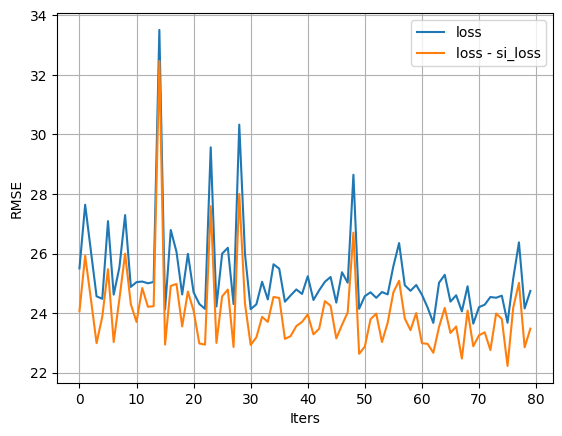

In [99]:
results_df = pd.DataFrame(results)

losses = results_df.loss.to_numpy()
si_losses = results_df.si_loss.to_numpy()

plt.plot(losses, label='loss')
plt.plot(losses-si_losses, label='loss - si_loss')
plt.legend()
plt.grid()
plt.ylabel('RMSE')
plt.xlabel('Iters')
# plt.ylim([23, 35])
# plt.yscale('log')
plt.show()

In [111]:
best_inds = np.where(losses-si_losses < 22.9)[0]
best_inds

array([27, 49, 50, 62, 67, 69, 72, 75, 78])

In [114]:
max_lr_arr = np.array(vals['max_lr'])
init_lr_ratio_arr = np.array(vals['init_lr_ratio'])
final_lr_ratio_arr = np.array(vals['final_lr_ratio'])
message_hidden_dim_arr = np.array(vals['message_hidden_dim'])
depth_arr = np.array(vals['depth'])
message_dropout_arr = np.array(vals['message_dropout'])
ffn_hidden_dim_arr = np.array(vals['ffn_hidden_dim'])
ffn_num_layers_arr = np.array(vals['ffn_num_layers'])
ffn_dropout_arr = np.array(vals['ffn_dropout'])


print(best_inds)
print(losses[best_inds])
print(losses[best_inds] - si_losses[best_inds])
print()
print(max_lr_arr[best_inds], 'max_lr')
print(init_lr_ratio_arr[best_inds], 'init_lr_ratio')
print(final_lr_ratio_arr[best_inds], 'final_lr_ratio')
print(message_hidden_dim_arr[best_inds], 'message_hidden_dim')
print(depth_arr[best_inds], 'depth')
print(message_dropout_arr[best_inds], 'message_dropout')
print(ffn_hidden_dim_arr[best_inds], 'ffn_hidden_dim')
print(ffn_num_layers_arr[best_inds], 'ffn_num_layers')
print(ffn_dropout_arr[best_inds], 'ffn_dropout')

[27 49 50 62 67 69 72 75 78]
[24.30686607 24.14785881 24.57372704 23.6750164  24.0621376  23.64914856
 24.54411278 23.68061142 24.16188278]
[22.86440127 22.63739693 22.87898289 22.67263808 22.47751762 22.88995846
 22.76277143 22.23104871 22.85548136]

[-2.4 -2.8 -2.4 -2.8 -2.8 -2.8 -3.2 -3.2 -3.2] max_lr
[-2. -1. -2. -1. -1. -1. -1. -1. -1.] init_lr_ratio
[-2. -2. -0. -1. -1. -1. -1. -1. -1.] final_lr_ratio
[5. 7. 9. 6. 6. 6. 6. 6. 6.] message_hidden_dim
[4. 6. 3. 6. 6. 6. 5. 6. 5.] depth
[0.2 0.2 0.4 0.4 0.2 0.2 0.2 0.2 0.2] message_dropout
[8. 9. 9. 8. 9. 9. 9. 9. 8.] ffn_hidden_dim
[4. 6. 4. 5. 5. 5. 4. 3. 3.] ffn_num_layers
[0.  0.2 0.  0.2 0.2 0.2 0.  0.  0. ] ffn_dropout


In [116]:
best_inds = [67, 69, 75]
best_inds

[67, 69, 75]

In [117]:
max_lr_arr = np.array(vals['max_lr'])
init_lr_ratio_arr = np.array(vals['init_lr_ratio'])
final_lr_ratio_arr = np.array(vals['final_lr_ratio'])
message_hidden_dim_arr = np.array(vals['message_hidden_dim'])
depth_arr = np.array(vals['depth'])
message_dropout_arr = np.array(vals['message_dropout'])
ffn_hidden_dim_arr = np.array(vals['ffn_hidden_dim'])
ffn_num_layers_arr = np.array(vals['ffn_num_layers'])
ffn_dropout_arr = np.array(vals['ffn_dropout'])


print(best_inds)
print(losses[best_inds])
print(losses[best_inds] - si_losses[best_inds])
print()
print(max_lr_arr[best_inds], 'max_lr')
print(init_lr_ratio_arr[best_inds], 'init_lr_ratio')
print(final_lr_ratio_arr[best_inds], 'final_lr_ratio')
print(message_hidden_dim_arr[best_inds], 'message_hidden_dim')
print(depth_arr[best_inds], 'depth')
print(message_dropout_arr[best_inds], 'message_dropout')
print(ffn_hidden_dim_arr[best_inds], 'ffn_hidden_dim')
print(ffn_num_layers_arr[best_inds], 'ffn_num_layers')
print(ffn_dropout_arr[best_inds], 'ffn_dropout')

[67, 69, 75]
[24.0621376  23.64914856 23.68061142]
[22.47751762 22.88995846 22.23104871]

[-2.8 -2.8 -3.2] max_lr
[-1. -1. -1.] init_lr_ratio
[-1. -1. -1.] final_lr_ratio
[6. 6. 6.] message_hidden_dim
[6. 6. 6.] depth
[0.2 0.2 0.2] message_dropout
[9. 9. 9.] ffn_hidden_dim
[5. 5. 3.] ffn_num_layers
[0.2 0.2 0. ] ffn_dropout


## Load checkpoint

In [182]:
checkpoint_path = f"{cv_dir}/m6/{ckpts[6]}"
mpnn_loaded_features = models.MPNN.load_from_checkpoint(checkpoint_path)
mpnn_loaded_features.eval()

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=64, bias=True)
    (W_h): Linear(in_features=64, out_features=64, bias=True)
    (W_o): Linear(in_features=136, out_features=64, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=512, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (2): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (3): Sequential(
        (0): ReLU()
        (1): 

In [183]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
next(mpnn_loaded_features.parameters()).is_cuda

True

In [184]:
mpnn_loaded_features = mpnn_loaded_features.cpu()

## XGB with DMPNN features

In [188]:
def featurize_dmpnn(smis):
    mol_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]
    mol_dset = data.MoleculeDataset(mol_data, featurizer)
    mol_loader = data.build_dataloader(mol_dset, shuffle=False)

    fingerprints = []
    with torch.no_grad():
        for batch in mol_loader:
            fingerprints.append(mpnn_loaded_features.fingerprint(batch.bmg, batch.V_d, batch.X_d))
    dmpnn_features = torch.cat(fingerprints, 0)
    dmpnn_features = dmpnn_features.detach()
    return np.array(dmpnn_features)

In [189]:
train_features_dmpnn = featurize_dmpnn(  #########
    training_smis,
)

train_features_dmpnn.shape            ##############

(1012, 64)

In [190]:
%%time
xgb = XGBRegressor(
    colsample_bytree=0.70,
    gamma=4,
    learning_rate=0.0492,
    max_depth=4,
    min_child_weight=15,
    n_estimators=312,
    reg_lambda=21,
    seed=42,
    # device='cuda',
    # n_jobs=multiprocessing.cpu_count() // 4
)

scores = -cross_val_score(xgb,   ####################
                          train_features_dmpnn,  ######################3########
                          targets, scoring='neg_root_mean_squared_error', cv=10)
print(f'CV val score: {scores.mean()} +/- {scores.std()}')

CV val score: 21.667397678673048 +/- 2.4429469361579548
CPU times: user 3min 11s, sys: 2.96 s, total: 3min 14s
Wall time: 3.04 s


In [193]:
xgb.fit(train_features_dmpnn, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0492, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=15, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=312, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### HP opt

In [173]:
%%time
param_grid = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 13),
    'learning_rate': Real(1e-3, 1e-1, prior='log-uniform'),
    'gamma': Integer(0, 15),
    'reg_lambda' : Integer(0, 50),
    'colsample_bytree' : Real(0.1, 1.0),
    'min_child_weight' : Integer(0, 30),
}

model = XGBRegressor(
    seed=42,
    # device='cuda',
    # n_jobs=multiprocessing.cpu_count() // 4
)

grid_xgb_dmpnn = BayesSearchCV(         ####################
    model,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_iter=256,
    n_points=32,
    n_jobs=32,
    cv=5,
    refit=True,
    return_train_score=True,
    verbose=1,
    random_state=42
)
grid_xgb_dmpnn.fit(train_features_dmpnn, targets)        ##################

print(f'Best score: {-grid_xgb_dmpnn.best_score_}')
print('Best params:')
print(grid_xgb_dmpnn.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best score: 20.7869084020442
Best params:
OrderedDict([('colsample_bytree', 0.7032273178521798), ('gamma', 4), ('learning_rate', 0.049185541531825895), ('max_depth', 4), ('min_child_weight', 15), ('n_estimators', 312), ('reg_lambda', 21)])
CPU times: user 7h 37min 1s, sys: 5min 39s, total: 7h 42min 41s
Wall time: 12min 34s


In [174]:
%%time
y_pred = grid_xgb_dmpnn.best_estimator_.predict(train_features_dmpnn)   #########
print(f'Train score: {root_mean_squared_error(y_pred, targets)}')
scores = -cross_val_score(grid_xgb_dmpnn.best_estimator_,   ####################
                          train_features_dmpnn,  ######################3########
                          targets, scoring='neg_root_mean_squared_error', cv=10)
print(f'CV val score: {scores.mean()} +/- {scores.std()}')

Train score: 10.37153000506279
CV val score: 20.699065341538667 +/- 2.310600170031665
CPU times: user 2min 45s, sys: 2.36 s, total: 2min 48s
Wall time: 2.63 s


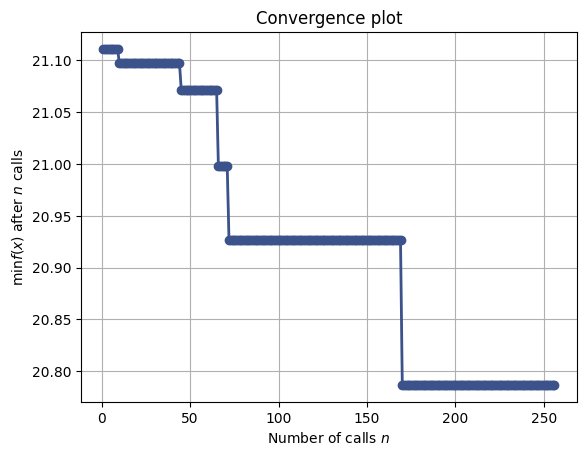

In [175]:
plot_convergence(grid_xgb_dmpnn.optimizer_results_)
plt.show()

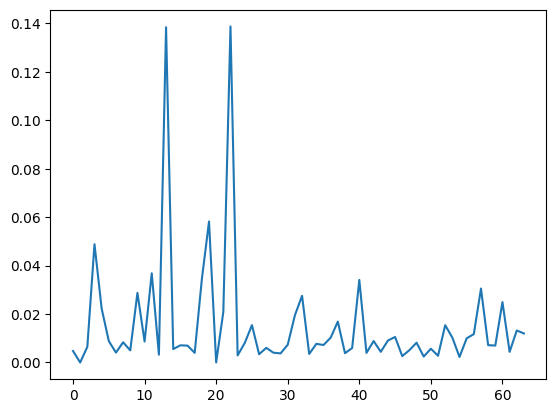

In [176]:
mol_feature_importances = grid_xgb_dmpnn.best_estimator_.feature_importances_
plt.plot(mol_feature_importances)
# plt.yscale('log')
plt.show()

In [177]:
joblib.dump(grid_xgb_dmpnn.best_estimator_, "xgb_dmpnn_1.pkl")  #########

['xgb_dmpnn_1.pkl']

### Predict

In [191]:
testing_features_dmpnn = featurize_dmpnn(  ###################
    testing_smis,
)

testing_features_dmpnn.shape    ###################

(500, 64)

In [194]:
ys_pred_testing = xgb.predict(testing_features_dmpnn) ##########

with open('pred_16.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Results'])
    for result in ys_pred_testing:
        writer.writerow([result])

## Select DMPNN features

In [ ]:
param_grid = {
    'model__n_estimators': Integer(100, 400),
    'model__max_depth': Integer(3, 13),
    'model__learning_rate': Real(1e-3, 1e-1, prior='log-uniform'),
    'model__gamma': Integer(0, 15),
    'model__reg_lambda' : Integer(0, 50),
    'model__colsample_bytree' : Real(0.1, 1.0),
    'model__min_child_weight' : Integer(0, 30),
}


selector = SelectFromModel(
    estimator=grid_xgb_dmpnn.best_estimator_,
    threshold=0.001,
)

model = XGBRegressor(
    seed=42,
    # device='cuda',
    # n_jobs=multiprocessing.cpu_count() // 4
)

pipe = Pipeline(steps=[
    ("selector", selector),
    ("model", model)
])

grid_select_1 = BayesSearchCV(
    pipe,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_iter=256,
    n_points=32,
    n_jobs=64,
    cv=5,
    refit=True,
    return_train_score=True,
    verbose=1,
    random_state=42
)
grid_select_1.fit(train_features_dmpnn, targets)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
